<span style="color:green; font-family:Papyrus; font-size:2em;">Data Cleaning and Feature Engineering </span>

This Notebook documents the various steps taken to do data cleaning and feature engineering.

<span style="color:red; font-family:Papyrus; font-size:1.5em;">Importing Libraries</span>

In [86]:
# import necessary libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import random

from isbnlib import is_isbn10, is_isbn13, info
import requests

from utils import *

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <span style="color:red; font-family:Papyrus; font-size:1.5em;">Data Cleaning: Raw Data</span>

- Fixing columns names and types and verifying valid values

The first time we ran the dataset via pandas, we ran into a problem. We found out that certain rows content separated by commas, and this confused pandas to interpret them as column section separator commas. Luckily, we noticed that the content was separated by not just a comma "," but by a comma and space ", ", which made it easy for us to think of solving the problem by replacing the comma with a slash. The new csv file after the update is called books_updated.csv. The following chunk can be uncommented to run it.

In [2]:
### COMMENT THE FOLLOWING CELL IF YOU HAVE ALREADY RUN IT BEFORE AND SAVED THE books_updated.csv ###
# # Specify the filename
filename = 'data/books.csv'
updated_filename = "data/books_updated.csv"

## In some cases in certain fields such us author the authors are separated by ", " 
## to avoid problems when reading the csv directly using pandas and to retain all rows the following steps done

# Open the file and read lines
with open(filename, 'r', encoding='utf-8') as file: # utf-8 encoding to support all languages since there is non-english content
    lines = file.readlines()

# Process the lines to handle unwanted delimiters
cleaned_lines = []
is_firstline = True # used to avoid updating the first line

for line in lines:
    if is_firstline: # if it is the first line i.e. Header do not update it
        is_firstline = False
        cleaned_lines.append(line)
        continue
    cleaned_line = line.replace(', ', '/')

    # Append the cleaned line
    cleaned_lines.append(cleaned_line)

# rejoin all the lines to create a new updated csv
with open(updated_filename, 'w', encoding='utf-8') as output_file:
    for cleaned_line in cleaned_lines:
        output_file.write(cleaned_line + '\n')

<span style="color:blue; font-family:Papyrus; font-size:1.5em;">Reading the Data</span>

In [3]:
# Read the cleaned data into a DataFrame
df = pd.read_csv(updated_filename, delimiter = ",", encoding = 'utf-8', index_col=False) 
# Look at the first 10 rows of the DataFrame
df.head(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books
8,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown


<span style="color:blue; font-family:Papyrus; font-size:1em;">num_pages column name</span>


- Looking closer at the column names, we notice that in the column '  num_pages' the name starts with space. For practical usage, it is better to remove this unnecessary space.

In [4]:
display(df.columns)
df.rename(columns={'  num_pages': '  num_pages'.replace(' ', '')}, inplace=True)
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

<span style="color:blue; font-family:Papyrus; font-size:1em;">Setting correct types & fixing ISBN</span>

- Examining the column types, it is noticed that some of the columns that are supposed to be numerical types are object types

In [5]:
types_columns=df.dtypes
number_lines, number_columns=df.shape
display(types_columns)
# investigate if there are non-numerical non-date types in supposedly numerical and date columns
# Display the non-numerical and non_date values of the selected columns
columns = ["isbn", "isbn13", "text_reviews_count"]
check_non_numerical_date(df, columns, "numerical")
check_non_numerical_date(df, ["publication_date"], "date")

bookID                 object
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                 object
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count     object
publication_date       object
publisher              object
dtype: object

The non_numerical_values in column isbn :  3        043965548X
12       076790818X
16       076790382X
27       097669400X
40       006076273X
            ...    
11090    030727411X
11101    074347788X
11106    057305133X
11110    843221728X
11115    972233168X
Name: isbn, Length: 985, dtype: object
The non_numerical_values in column isbn13 :  1847    en-US
Name: isbn13, dtype: object
The non_numerical_values in column text_reviews_count :  1847    9/1/2003
Name: text_reviews_count, dtype: object
The non_date_values in column publication_date :  1847      MTV Books
8180     11/31/2000
11098     6/31/1982
Name: publication_date, dtype: object


From the above investigation one can notice the following : 
- We notice that at index 1847 the data is shifted to the left
- Dates at indices 8180 and 11098 were not considered as dates since they are wrong. June and November are 31 days, but in reality they are only 30 days.
- isbn is not numerical since some of the isbn codes end with X 

Before we begin fixing the above two issues, it is important to clarify that 10-digit ISBNs have a X at the end to represent 10. On the other hand, 13-digit ISBNs do not have a X. This is why we chose 13-digit ISBN to be numeric and not 10-digit ISBN.

For the 13-digit ISBN we will try to fix the non-numeric value that exists in it; whereas, for the 10-digit ISBN, we will try to verify if it has invalid ISBN values. THANKFULLY, using the isbnlib library, we verify that all the equivalent 13-digit ISBNs of the non-valid 10-digit ISBNs are valid, which helped us quickly retrieve the valid 10-digit ISBN. We pay attention to the 10-digit ISBN because it is the one with the least non-valid values (5) compared to the 13-digit one (29). The 10-digit ISBN will help us to scrape the genre and country of books with too much complexity.

In [6]:
s = df["isbn"]
non_valid_isbn10 = []
# get non valid isbn
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        non_valid_isbn10.append((i, df[["isbn", "isbn13"]].loc[i]))
display(non_valid_isbn10)
df["isbn"].iloc[1032] = "0312349483"
df["isbn"].iloc[1847] = "0743470796"
df["isbn"].iloc[3110] = "0842386874"
df["isbn"].iloc[9359] = "1903254388"
df["isbn"].iloc[10330] = "0449015416"
# test
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        print("invalid ISBN found")

[(1032,
  isbn         0312349486
  isbn13    9780312349486
  Name: 1032, dtype: object),
 (1847,
  isbn      9780743470797
  isbn13            en-US
  Name: 1847, dtype: object),
 (3110,
  isbn          084386874
  isbn13    9780842386876
  Name: 3110, dtype: object),
 (9359,
  isbn         9781903254
  isbn13    9781903254387
  Name: 9359, dtype: object),
 (10330,
  isbn         4490249512
  isbn13    9780449015414
  Name: 10330, dtype: object)]

In [7]:
# fix the dates by replacing 31 with 30 in June and November
# convert the date column to type pd.datetime
df["publication_date"].iloc[8180] = '11/30/2000'
df["publication_date"].iloc[11098] = '6/30/1982'

<span style="color:blue; font-family:Papyrus; font-size:1em;">Unshifting data at index 1847</span>

Now we investigate row 1847. One can notice that there is a / in the bookID which separates the bookID from the book title. This must be the result of the updates we did to the original csv file in the beginning, which led to the shift.

In [8]:
display(df.iloc[1847])
display(df["publisher"][df["publisher"].isna()==True])

bookID                6549/ said the shotgun to the head.
title                                       Saul Williams
authors                                              4.22
average_rating                                743470796.0
isbn                                           0743470796
isbn13                                              en-US
language_code                                         192
num_pages                                            2762
ratings_count                                         214
text_reviews_count                               9/1/2003
publication_date                                MTV Books
publisher                                             NaN
Name: 1847, dtype: object

1847    NaN
Name: publisher, dtype: object

In [9]:
bookid_title = df["bookID"].iloc[1847].split('/')

# content of the remaining columns
remaining_columns = df[['title', 'authors', 'average_rating', 'isbn', 'isbn13',
                                   'language_code', 'num_pages', 'ratings_count', 
                                   'text_reviews_count', 'publication_date']].iloc[1847]

# rearrange cells content for each column
df.iloc[1847, 2:] = remaining_columns
df["bookID"].iloc[1847]= bookid_title[0]
df["title"].iloc[1847]= bookid_title[1]
display(df.iloc[1847])

bookID                                          6549
title                  said the shotgun to the head.
authors                                Saul Williams
average_rating                                  4.22
isbn                                     743470796.0
isbn13                                    0743470796
language_code                                  en-US
num_pages                                        192
ratings_count                                   2762
text_reviews_count                               214
publication_date                            9/1/2003
publisher                                  MTV Books
Name: 1847, dtype: object

In [10]:
# We manually update the isbn at index 1847 as well to remove the .0 from the end
df["isbn"].iloc[1847] = "0743470796"

Now, we check the final results, but for some reasons (has to do with pandas versions) the supposedly numerical columns became objects, which is can be read from the first call to df.info(). We fix again, and can verify that everything is Ok with the last call to df.info()


In [11]:
# Check the types of the columns
display(df.info())
# re-investigate if there is non-numerical content in supposedly numerical columns
columns = ["bookID", "average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]
check_non_numerical_date(df, columns, "numerical")
# If they do not contain non-numerical content, we will transform them to numerical
columns = ["bookID", "average_rating", "isbn13", "text_reviews_count", "num_pages", "ratings_count", "text_reviews_count"]
df = convert_to_numerical(df, columns)
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bookID              11127 non-null  object
 1   title               11127 non-null  object
 2   authors             11127 non-null  object
 3   average_rating      11127 non-null  object
 4   isbn                11127 non-null  object
 5   isbn13              11127 non-null  object
 6   language_code       11127 non-null  object
 7   num_pages           11127 non-null  object
 8   ratings_count       11127 non-null  int64 
 9   text_reviews_count  11127 non-null  object
 10  publication_date    11127 non-null  object
 11  publisher           11127 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.0+ MB


None

The non_numerical_values in column bookID :  Series([], Name: bookID, dtype: object)
The non_numerical_values in column average_rating :  Series([], Name: average_rating, dtype: object)
The non_numerical_values in column isbn13 :  Series([], Name: isbn13, dtype: object)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)
The non_numerical_values in column num_pages :  Series([], Name: num_pages, dtype: object)
The non_numerical_values in column ratings_count :  Series([], Name: ratings_count, dtype: int64)
The non_numerical_values in column text_reviews_count :  Series([], Name: text_reviews_count, dtype: object)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors     

None

In [12]:
# Finally we check ISBN
s = df["isbn"]
non_valid_isbn10 = []
for i in range(len(s)):
    if is_isbn10(s[i]) == False:
        non_valid_isbn10.append((i, df[["isbn", "isbn13"]].loc[i]))
display(non_valid_isbn10)

[]

In [ ]:
# save to csv
df.to_csv("data/books_updated.csv", index_label=False) # index_label = False so that it does not add another index label to the DataFrame

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Getting Genre & Country</span>

At this step, three new features are added: 

- publisher_country : this is the country of the publisher. It is extracted using the isbn
- coordinates : this is the coordinates of the country. It is important in the data analysis and visualization. countries.csv is used to get the coordinates
- genre_category : this represents the genre of the book. It was extracted using google books API. **Note that the process to get the genre takes around 1 hour and half.**

In [14]:
# isbnlib for Country
def new_col(row):
    ctr_lang = info(str(row['isbn'])) # get language from isbn
    if ctr_lang == "English language":
        return random.choice(["United Kingdom", "United States"]) # if english return randomly either "United Kingdom" or "United States"
    elif ctr_lang == "French language":
        return "France"
    elif ctr_lang == "German language":
        return "Germany"
    elif ctr_lang == "former U.S.S.R":
        return "Russia"
    elif ctr_lang == "former Yugoslavia":
        return "Croatia"
    elif ctr_lang == "Hong Kong, China":
        return "China"
    else:
        return ctr_lang
    
df["publisher_country"] = df.apply(new_col, axis=1)

countries = pd.read_csv("data/countries.csv").rename(columns={"name":"publisher_country"})
df = pd.merge(df, countries, on = "publisher_country")
df["coordinates"] = df[["latitude","longitude"]].apply(tuple, axis=1)

In [15]:
df.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates
4626,38892,Mistletoe,Hailey Abbott/Melissa de la Cruz/Aimee Friedma...,3.41,0439863686,9780439863681,eng,222,541,57,10/1/2006,Scholastic Paperbacks,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
5074,43681,A Garden Of Vipers (Carson Ryder #3),Jack Kerley,3.96,0451412338,9780451412331,en-US,400,562,37,2/6/2007,Onyx,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
4807,41046,Romanticism,Hugh Honour,3.75,0064300897,9780064300896,eng,416,42,2,8/15/1979,Westview Press,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)"
9450,33723,Girls' Night In,Lauren Henderson/Chris Manby/Sarah Mlynowski/J...,3.63,0373250746,9780373250745,eng,325,12765,185,8/25/2004,Red Dress Ink,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"
8362,24472,Peony in Love,Lisa See,3.60,140006466X,9781400064663,eng,273,37411,3719,6/26/2007,Random House,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)"


In [16]:
# Google Book for Genre
def get_genre(row):
    isbn = str(row["isbn"])
    response = requests.get('https://www.googleapis.com/books/v1/volumes?q=isbn:'+isbn)
    resp_json_payload = response.json()
    try:
        res = resp_json_payload['items'][0]['volumeInfo']['categories']
        return res[0]
    except:
        return random.choice(["Fiction", "Juvenile Fiction", "Biography & Autobiography"])
    
df["genre_category"] = df.apply(get_genre, axis=1)
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates,genre_category
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction
1,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Juvenile Fiction
2,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9789722332200,por,149,211,24,7/17/2004,Editorial Presença,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children's stories
11123,45617,O Cavalo e o Seu Rapaz (As Crónicas de Nárnia ...,C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,3.92,9722330551,9789722330558,por,160,207,16,8/15/2003,Editorial Presença,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Fiction
11124,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9789722329989,por,147,396,37,4/8/2003,Editorial Presença,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children
11125,45625,A Viagem do Caminheiro da Alvorada (As Crónica...,C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9789722331326,por,176,161,14,9/1/2004,Editorial Presença,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Juvenile Fiction


In [19]:
df.sample(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publisher_country,country,latitude,longitude,coordinates,genre_category
10686,18404,El club Dante,Matthew Pearl/Vicente Villacampa,3.38,8432296325,9788432296321,spa,464,57,2,8/30/2004,Seix Barral,Spain,ES,40.463667,-3.749220,"(40.463667, -3.74922)",Authors
7109,13820,Manna from Heaven,Roger Zelazny/Scott Zrubeck/Steven Brust,3.95,0809530953,9780809530953,en-US,255,337,10,5/29/2006,Wildside Press,United States,US,37.090240,-95.712891,"(37.09024, -95.712891)","Science fiction, American"
1931,14349,The Pearl/The Red Pony,John Steinbeck,3.64,0140042326,9780140042320,eng,181,1469,39,9/30/1976,Penguin Books,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Biography & Autobiography


Save to CSV

In [20]:
df.to_csv("data/books_updated_w_cnt_gnre.csv", index_label=False) # index_label = False so that it does not add another index label to the DataFrame

## <span style="color:red; font-family:Papyrus; font-size:1.5em;">Data Cleaning: Scraped Data</span>

This data cleaning is done on the data set after doing webscraping. We did two webscraping, one through Goodreads (found in scraper folder), and the second through Google Books, as seen above. We also used an ISBN Python library to extract the country feature. 

Through Goodreads extra features were extracted which are: 
- first_published : this is the date a book was first published (this will help distinguish two different books with the same name)
- book_format : this is the format of the book (some books are present in different formats (paperback, Audio CD, hardcover))
- new_publisher: this is because it was noticed that in the original data some books had wrong publishers
- edition_avgRating: this is the actual average rating of each edition
- added_toShelves: this is the number of users that added a book to shelves

Through Google Books the feature that was extracted is:
- genre_category : this represents the genre of the book

Through Python Library isbnlib the feature that was extracted is:
- publisher_country :  this is the country of the publisher

*For more details about the process of GoodReads scraping, please refer to scraper/scraper.py*

### <span style="color:blue; font-family:Papyrus; font-size:1.5em;">Reading the Data</span>

In [87]:
# read the scraped data
goodread_scraped = pd.read_csv("scraper/booksRating_extraFeats.csv")
goodread_scraped = goodread_scraped[["first_published", "book_format", "new_publisher", "edition_avgRating", "added_toShelves"]]
df = pd.read_csv("data/books_updated_w_cnt_gnre.csv")

# concat the dataframe processed above (df) to new features extracted from the good reads scraping 
df_scraped = pd.concat([df, goodread_scraped], axis=1).reindex(df.index)
df_scraped.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,country,latitude,longitude,coordinates,genre_category,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 16, 2005",Paperback,Scholastic Inc,4.57,4405980.0
1,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Juvenile Fiction,"June 21, 2003",Paperback,Scholastic Inc.,4.50,4518536.0
2,12,The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 2, 1998",Hardcover,NaN,4.05,7469.0
3,13,The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 8, 1999",Mass Market Paperback,Scholastic Inc.,4.57,5223956.0
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1),Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"October 1, 2003",Paperback,Scholastic,4.72,172736.0


In [88]:
df_scraped.tail()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,country,latitude,longitude,coordinates,genre_category,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
11122,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9789722332200,por,149,211,24,...,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children's stories,"December 1, 2004",Paperback,Da Capo Press,4.06,552.0
11123,45617,O Cavalo e o Seu Rapaz (As Crónicas de Nárnia #3),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,3.92,9722330551,9789722330558,por,160,207,16,...,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Fiction,"June 27, 1987",Paperback,Penguin Books,4.04,4269.0
11124,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9789722329989,por,147,396,37,...,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children,"January 1, 1990",Paperback,Penguin Publishing Group,3.98,4686.0
11125,45625,A Viagem do Caminheiro da Alvorada (As Crónicas de Nárnia #5),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9789722331326,por,176,161,14,...,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Juvenile Fiction,"January 1, 2007",Hardcover,Ecco,3.75,2948.0
11126,45626,O Príncipe Caspian (As Crónicas de Nárnia #4),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,3.97,9722330977,9789722330978,por,160,215,11,...,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Fantasy,"June 1, 1876",Paperback,NaN,3.72,228.0


In [89]:
df_scraped.info()
# df_scraped.isnull().any()
df_scraped.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 11127 entries, 0 to 11126
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
 12  publisher_country   11127 non-null  object 
 13  country             11127 non-null  object 
 14  latitude            11127 non-null  float64
 15  longitude           11127 non-null  float64
 16  coordinat

bookID                  0
title                   0
authors                 0
average_rating          0
isbn                    0
                     ... 
first_published         2
book_format             1
new_publisher        2767
edition_avgRating       3
added_toShelves         3
Length: 23, dtype: int64

### <span style="color:blue; font-family:Papyrus; font-size:1.5em;">Imputation</span>

In the new dataset, there are 2 NaN in the first_published, 1 in the book_format, 3 in both the edition_avgRating and added_toShelves. These were values that the scraper failed to get. Since they are very few, they will be filled manually. 

In [90]:
df_scraped[df_scraped[["first_published", "book_format", "edition_avgRating", "added_toShelves"]].isna().any(axis=1)]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,country,latitude,longitude,coordinates,genre_category,first_published,book_format,new_publisher,edition_avgRating,added_toShelves
2255,17043,Essentials of American Government: Continuity and Change,Karen O'Connor/Larry J. Sabato,3.50,032127623X,9780321276230,eng,604,4,0,...,GB,55.378051,-3.435973,"(55.378051, -3.435973)",United States,"January 1, 1970",Paperback,Atheneum Books for Young Readers,NaN,NaN
6396,8552,Bolt (Kit Fielding #2),Dick Francis,4.04,0425202887,9780425202883,eng,288,5043,121,...,US,37.090240,-95.712891,"(37.09024, -95.712891)",Fiction,NaN,NaN,NaN,NaN,NaN
8476,25175,The Anodyne Necklace (Richard Jury #3),Martha Grimes,4.04,0451410890,9780451410894,eng,310,6046,174,...,US,37.090240,-95.712891,"(37.09024, -95.712891)",Fiction,NaN,Paperback,Barnes & Noble Classics,4.36,92622.0
8520,25653,The Minimalist Cooks at Home: Recipes That Give You More Flavor from Fewer Ingredients in Less Time,Mark Bittman,3.90,0767909267,9780767909266,eng,240,261,20,...,US,37.090240,-95.712891,"(37.09024, -95.712891)",Cookery,"January 1, 2001",Mass Market Paperback,Hyperion,NaN,NaN


In [91]:
df_scraped.loc[2255, ["edition_avgRating", "added_toShelves"]] = [4.11, 5402]
# As the information on the goodreads page are not exactly the same as the ones in line 6385, the information is refilled manually based on the GoddReads page (the title, num_pages and average rating were the same in the database and the link to goodread).
df_scraped.loc[6396, ["ratings_count", "text_reviews_count", "first_published","book_format","new_publisher","edition_avgRating","added_toShelves"]] = [1659,66,"July 1, 2003","Paperback","Scholastic",3.78,3004]
df_scraped.loc[8476, ["first_published"]] = ["January 1, 1843"]
df_scraped.loc[8520, ["edition_avgRating", "added_toShelves"]] = [3.7, 15942]

For the new_publisher, the scraper failed to retrieve a lot of values, this is because of how the publisher is saved in the html. Due to the constraint of time, and since there is already a publisher column in the original dataset, we will update the old publisher only when both values exist and both are different.

In [92]:
for index, row in df_scraped.iterrows():
    # Check if the new publisher is different from the old publisher
    if pd.notna(row['new_publisher']) and row['new_publisher'] != row['publisher']:
        # Update the publisher with the new publisher value
        df_scraped.at[index, 'publisher'] = row['new_publisher']
    else:
        # Use the old publisher if the new publisher is NaN or the same as the old publisher
        df_scraped.at[index, 'publisher'] = row['publisher']

display(df_scraped[["publisher", "new_publisher"]].sample(5))
# drop new_publisher column
df_scraped.drop(columns="new_publisher", inplace=True)
display(df_scraped)

,publisher,new_publisher
1161,William Morrow Paperbacks,NaN
6624,Bloomsbury Publishing PLC,Bloomsbury Publishing PLC
1132,IVP Academic,IVP Academic
7724,Vintage,Vintage
9496,Berkley Sensation,Berkley Sensation


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 16, 2005",Paperback,4.57,4405980.0
1,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Juvenile Fiction,"June 21, 2003",Paperback,4.50,4518536.0
2,12,The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 2, 1998",Hardcover,4.05,7469.0
3,13,The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 8, 1999",Mass Market Paperback,4.57,5223956.0
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1),Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"October 1, 2003",Paperback,4.72,172736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9789722332200,por,149,211,24,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children's stories,"December 1, 2004",Paperback,4.06,552.0
11123,45617,O Cavalo e o Seu Rapaz (As Crónicas de Nárnia #3),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,3.92,9722330551,9789722330558,por,160,207,16,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Fiction,"June 27, 1987",Paperback,4.04,4269.0
11124,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9789722329989,por,147,396,37,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children,"January 1, 1990",Paperback,3.98,4686.0
11125,45625,A Viagem do Caminheiro da Alvorada (As Crónicas de Nárnia #5),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9789722331326,por,176,161,14,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Juvenile Fiction,"January 1, 2007",Hardcover,3.75,2948.0


In [93]:
display(df_scraped)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 16, 2005",Paperback,4.57,4405980.0
1,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Juvenile Fiction,"June 21, 2003",Paperback,4.50,4518536.0
2,12,The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 2, 1998",Hardcover,4.05,7469.0
3,13,The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1-5),Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"July 8, 1999",Mass Market Paperback,4.57,5223956.0
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1),Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,United Kingdom,GB,55.378051,-3.435973,"(55.378051, -3.435973)",Fiction,"October 1, 2003",Paperback,4.72,172736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,A Última Batalha (As Crónicas de Nárnia #7),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.03,9722332201,9789722332200,por,149,211,24,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children's stories,"December 1, 2004",Paperback,4.06,552.0
11123,45617,O Cavalo e o Seu Rapaz (As Crónicas de Nárnia #3),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,3.92,9722330551,9789722330558,por,160,207,16,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Fiction,"June 27, 1987",Paperback,4.04,4269.0
11124,45623,O Sobrinho do Mágico (As Crónicas de Nárnia #1),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.04,9722329987,9789722329989,por,147,396,37,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Children,"January 1, 1990",Paperback,3.98,4686.0
11125,45625,A Viagem do Caminheiro da Alvorada (As Crónicas de Nárnia #5),C.S. Lewis/Pauline Baynes/Ana Falcão Bastos,4.09,9722331329,9789722331326,por,176,161,14,...,Portugal,PT,39.399872,-8.224454,"(39.399872, -8.224454)",Juvenile Fiction,"January 1, 2007",Hardcover,3.75,2948.0


By insepcting the data more, we notice that sometimes the dates in the first_published weren't extracted correctly, for example instead of January we find "ary".

In [94]:
display(df_scraped.first_published.sample(5))
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains(r'\bary\b', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)]
# We will replace the "ary" in those line by "february" 
# Filter rows containing "ary" but not "january" or "february"
filtered_rows = df_scraped['first_published'].str.contains(r'ary', case=False) & ~df_scraped['first_published'].str.contains(r'january|february', case=False)
# Replace the filtered results with "february" 
df_scraped.loc[filtered_rows, 'first_published'] = df_scraped.loc[filtered_rows, 'first_published'].str.replace(r'ary', 'february', case=False) # we don't need =
df_scraped[['title','first_published']][df_scraped['first_published'].str.contains('published', case=False)]
# Let's delete the word "published" from the first_published column
df_scraped['first_published'] = df_scraped['first_published'].str.replace('published ', '')

5117     January 1, 1988
5896     August 30, 2001
2930     January 1, 2000
3250       June 26, 2007
11014       May 28, 2006
Name: first_published, dtype: object

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Text Columns to Lower Case</span>

When dealing with text data it always safer to have them all in the same case either lower or upper 

In [95]:
# get the text columns
text_columns = df_scraped.select_dtypes(include=['object'], )
text_columns = text_columns.loc[:, text_columns.columns != 'coordinates'].columns
# Convert to lowercase
df_scraped = to_lower(df_scraped, text_columns)
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,publisher_country,country,latitude,longitude,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves
4996,42955,the drifters,james a. michener,4.04,0449213536,9780449213537,eng,768,6253,353,...,united kingdom,gb,55.378051,-3.435973,"(55.378051, -3.435973)","africa, north","january 1, 1922",paperback,3.91,18.0
231,1506,cliffsnotes on euripides' medea and electra,robert j. milch,4.20,0822004240,9780822004240,eng,69,5,0,...,united kingdom,gb,55.378051,-3.435973,"(55.378051, -3.435973)",cliffs notes,"december 1, 2002",paperback,4.08,62.0
5765,3688,complete short stories,graham greene/pico iyer,4.17,0143039105,9780143039105,eng,594,1122,69,...,united states,us,37.090240,-95.712891,"(37.09024, -95.712891)",fiction,"december 1, 1974",paperback,4.15,247430.0
5264,22,bill bryson's african diary,bill bryson,3.44,0767915062,9780767915069,eng,55,7270,499,...,united states,us,37.090240,-95.712891,"(37.09024, -95.712891)",travel,"february 1, 1999",paperback,3.39,1007.0
3375,27247,the complete book of home site and office security: selecting installing and troubleshooting systems and devices,bill phillips,3.50,0071467440,9780071467445,eng,309,2,0,...,united kingdom,gb,55.378051,-3.435973,"(55.378051, -3.435973)",dwellings,"january 1, 1967",unknown binding,4.10,13209.0


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create num_contributors</span>

We have decided to take only the name of the first author, since usually first authors are the main authors. num_contributors column will be added to indicate the total number of authors/contributors to the book.

In [96]:
# take the first author in the authors column
df_scraped["first_author"] = df_scraped["authors"].apply(lambda x: x.split("/")[0].strip())
df_scraped["first_author"].sample(5)
df_scraped["num_contributors"] = df_scraped["authors"].apply(lambda x: len(x.split("/")))
df_scraped[["authors","num_contributors"]].sample(5)

,authors,num_contributors
9688,anya seton,1
7102,chie shinohara,1
10250,alden t. vaughan,1
6778,saul bellow,1
9389,frances gies/joseph gies,2


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Clean Text Columns</span>

Remove punctuation, and extra white spaces from all text columns. We'd also better clean the text in publisher column, to avoid having same publishers represented differently. 
Example: indexes 5993, 5365 and 9753, W.W. Norton & Company, W. W. Norton and Company and W. W. Norton  Company represent the same publisher

In [97]:
general_replacements = [
    (r'[^\w\s]', ''), # remove punctuation
    (r'\s\s+', " "), # remove double spaces and more
]
columns_ = ["title", "first_author"]
df_scraped = sub_text(df_scraped, columns_, general_replacements)
# strip to remove spaces from beginning and end
df_scraped["title"] = df_scraped["title"].str.strip()
df_scraped["first_author"] = df_scraped["first_author"].str.strip()
df_scraped[["title", "first_author"]].sample(5)

# specific replacements on publishers
specific_replacements = [
    (r'\binc.?\b', ""), #remove inc
    (r'\bllc.?\b', ""), #remove llc
    (r'\bltd.?\b', ""), #remove ltd
    (r"w. w.", "ww"), #convert w. w. to ww
    (r"&", " and "), #substiute & by and
    (r'\([^)]*\)', ''), #remove everything within parentheses
    (r"\bpaperbacks?\b", ""), #remove paperback or paperbacks
    (r'\bbooks?\b', ""),  #remove book and books
    (r'\bclassics?\b', ""), #remove classic and classics
    (r'\bpublishers?\b', ""), #remove publisher or publishers
    (r'\bpress\b', ""), #remove press
    (r'\bpublishing\b', ""), #remove publishing
    (r'\bpublications?\b', ""), #remove publication or publications
    (r'\bgroups?\b', "") #remove group or groups
]
df_scraped = sub_text(df_scraped, ["publisher"], specific_replacements)
#apply the general replacements on the publisher column 
df_scraped = sub_text(df_scraped, ["publisher"], general_replacements)
# strip to remove spaces from beginning and end
df_scraped["publisher"] = df_scraped["publisher"].str.strip()
df_scraped.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,latitude,longitude,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors
7325,15600,the midwifes tale,gretchen moran laskas,3.83,0385335547,9780385335546,eng,256,705,99,...,37.09024,-95.712891,"(37.09024, -95.712891)",fiction,"december 2, 2003",mass market paperback,4.15,2156.0,gretchen moran laskas,1
5527,1850,born to be wild,catherine coulter,3.78,0515142395,9780515142396,eng,354,2456,115,...,37.09024,-95.712891,"(37.09024, -95.712891)",fiction,"september 1, 1984",paperback,3.57,125.0,catherine coulter,1
7747,18816,problems of dostoevskys poetics,mikhail bakhtin/caryl emerson,4.34,0816612285,9780816612284,eng,334,641,29,...,37.09024,-95.712891,"(37.09024, -95.712891)",literary criticism,"january 1, 376",paperback,4.00,30.0,mikhail bakhtin,2
5433,1255,leadership in organizations,gary yukl,3.68,0131494848,9780131494848,en-gb,542,55,4,...,37.09024,-95.712891,"(37.09024, -95.712891)",business & economics,"january 1, 2003",paperback,3.81,169532.0,gary yukl,1
7203,14477,teach us amelia bedelia,peggy parish/lynn sweat,4.21,0060511141,9780060511142,eng,64,3134,98,...,37.09024,-95.712891,"(37.09024, -95.712891)",juvenile fiction,"july 1, 2003",hardcover,4.59,69.0,peggy parish,2


### <span style="color:blue; font-family:Papyrus; font-size:1em;">edition_avgRating vs. average_rating</span>

We have a look at the edition_avgRating to see if it differs a lot from the original average_rating

In [98]:
display(df_scraped['edition_avgRating'].isna().any())
df_rating = df_scraped.copy()
df_rating['diff_rating'] = df_rating['average_rating'] - df_rating['edition_avgRating']
filtered_df = df_rating[df_rating['diff_rating'] != 0]
# Check cases when the average_rating is different from edition_avgRating
display(filtered_df[['title', 'average_rating', 'edition_avgRating']].sample(10))
display('The average mean of difference between average rating and edition rating is ', round(df_rating['diff_rating'].mean(), 2) )

False

,title,average_rating,edition_avgRating
5927,you shall know our velocity,3.63,3.61
308,harry potter schoolbooks box set two classic books from the library of hogwarts school of witchcraft and wizardry,4.40,3.50
3994,king henry iv part 2,3.80,4.27
6323,maud hart lovelaces deep valley a guidebook of mankato places in the betsytacy series,4.29,3.74
1338,the worlds religions,4.07,3.88
5579,flaubert in egypt a sensibility on tour,3.62,4.01
9287,dragons of eden speculations on the evolution of human intelligence,4.18,3.50
2792,relic pendergast 1,4.02,3.80
564,miss happiness and miss flower,4.27,4.04
1377,stationary bike,3.54,3.61


'The average mean of difference between average rating and edition rating is '

0.03

Distribution of average rating vs. edition rating

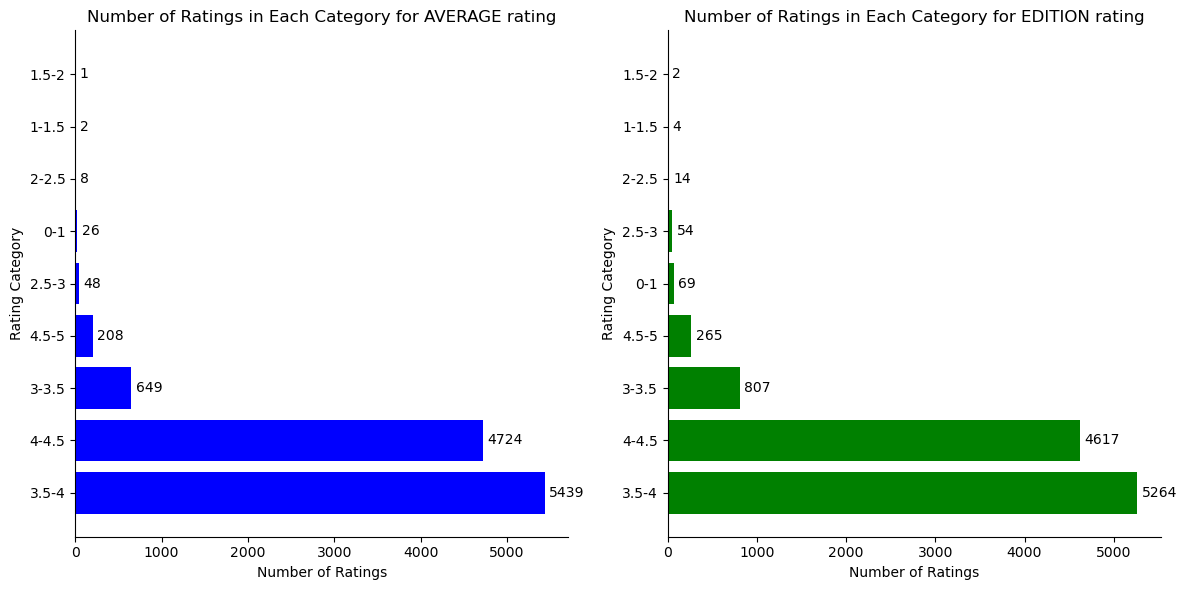

In [99]:
#We need to know if the distribution is the same for average rating or edition rating :
# Define bins and labels for average rating and edition rating
bins = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = ['0-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5']

# Create a new column with the bin labels for average rating and edition rating
df_rating['average_rating_category'] = pd.cut(df_rating['average_rating'], bins=bins, labels=labels, right=False)
df_rating['edition_rating_category'] = pd.cut(df_rating['edition_avgRating'], bins=bins, labels=labels, right=False)

# Count the number of ratings in each category for both
rating_counts_per_category_average = df_rating['average_rating_category'].value_counts()
rating_counts_per_category_edition = df_rating['edition_rating_category'].value_counts()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph based on df_scraped['average_rating']
axs[0].barh(rating_counts_per_category_average.index, rating_counts_per_category_average.values, color='blue')
axs[0].set_title('Number of Ratings in Each Category for AVERAGE rating')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Rating Category')

# Add values on top of each bar for the first graph
for index, value in enumerate(rating_counts_per_category_average):
    axs[0].text(value+50, index, str(value), ha='left', va='center')

# Plot the second graph based on df_scraped['edition_avgRating']
axs[1].barh(rating_counts_per_category_edition.index, rating_counts_per_category_edition.values, color='green')
axs[1].set_title('Number of Ratings in Each Category for EDITION rating')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Rating Category')

# Add values on top of each bar for the second graph
for index, value in enumerate(rating_counts_per_category_edition):
    axs[1].text(value+50, index, str(value), ha='left', va='center')

# Remove upper and right borders for both subplots
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

When we look at the ratings for each edition, there is very slight improvement in the data imbalance. Yet, we notice that there are more ratings below 3, which are categories with very fewer ratings. However, looking at the mean calculated for the difference of the two ratings, we see that it is very small = 0.03. So for the vast majority of books, there is very few differences between the 2 ratings. In order to have more specific ratings, and to add more relevance to the new data scraped (like book format) and more coherence to already existing data (publication_date and number_of_pages which are specific to the edition), we will now only refer to the edition_avgRating column and drop the average_rating.

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create size_of_publisher</span>

The exact number of times a publisher name is in the database is not as relevant as the number of time an author or a title is in it.
So instead of the count, create a column that categorize the publisher :
- Small publisher (1) = 10 or less times in the database
- Medium publisher (2) = between 10 annd 30 times
- big publisher (3) = more that 30 times

In [100]:
# Adding the new columns that allows to see if a publisher is often cited
df_scraped['publisher_count'] = df_scraped.groupby('publisher')['publisher'].transform('count')
publisher_count_ranges = [0, 11, 31, float('inf')] # [0, 10] --> 1 - [11, 30] --> 2, [30, +inf] --> 3
df_scraped['size_of_publisher'] = pd.cut(df_scraped['publisher_count'], bins=publisher_count_ranges, labels=[1, 2, 3], right=False)
print('Number of line with small publisher',len(df_scraped[df_scraped['size_of_publisher'] == 1]))
print('Number of line with medium publisher',len(df_scraped[df_scraped['size_of_publisher'] == 2]))
print('Number of line with big publisher', len(df_scraped[df_scraped['size_of_publisher'] == 3]))
# Now that we have the "size_of_publisher" column, let's delete the "publisher_count" used to create it 
df_scraped.drop(columns=['publisher_count'], inplace=True)
df_scraped

Number of line with small publisher 3627
Number of line with medium publisher 2191
Number of line with big publisher 5309


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,longitude,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,-3.435973,"(55.378051, -3.435973)",fiction,"july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3
1,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,-3.435973,"(55.378051, -3.435973)",juvenile fiction,"june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3
2,12,the ultimate hitchhikers guide five complete novels and one story hitchhikers guide to the galaxy 15,douglas adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,-3.435973,"(55.378051, -3.435973)",fiction,"july 2, 1998",hardcover,4.05,7469.0,douglas adams,1,2
3,13,the ultimate hitchhikers guide to the galaxy hitchhikers guide to the galaxy 15,douglas adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,-3.435973,"(55.378051, -3.435973)",fiction,"july 8, 1999",mass market paperback,4.57,5223956.0,douglas adams,1,3
4,14,the hitchhikers guide to the galaxy hitchhikers guide to the galaxy 1,douglas adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,-3.435973,"(55.378051, -3.435973)",fiction,"october 1, 2003",paperback,4.72,172736.0,douglas adams,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,a última batalha as crónicas de nárnia 7,c.s. lewis/pauline baynes/ana falcão bastos,4.03,9722332201,9789722332200,por,149,211,24,...,-8.224454,"(39.399872, -8.224454)",children's stories,"december 1, 2004",paperback,4.06,552.0,cs lewis,3,2
11123,45617,o cavalo e o seu rapaz as crónicas de nárnia 3,c.s. lewis/pauline baynes/ana falcão bastos,3.92,9722330551,9789722330558,por,160,207,16,...,-8.224454,"(39.399872, -8.224454)",fiction,"june 27, 1987",paperback,4.04,4269.0,cs lewis,3,3
11124,45623,o sobrinho do mágico as crónicas de nárnia 1,c.s. lewis/pauline baynes/ana falcão bastos,4.04,9722329987,9789722329989,por,147,396,37,...,-8.224454,"(39.399872, -8.224454)",children,"january 1, 1990",paperback,3.98,4686.0,cs lewis,3,3
11125,45625,a viagem do caminheiro da alvorada as crónicas de nárnia 5,c.s. lewis/pauline baynes/ana falcão bastos,4.09,9722331329,9789722331326,por,176,161,14,...,-8.224454,"(39.399872, -8.224454)",juvenile fiction,"january 1, 2007",hardcover,3.75,2948.0,cs lewis,3,3


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create size_of_author</span>

Similar as we did with publisher, we can create a column called size_of_author which signifies the number of books this author contirbuted to. 
- Small author (1) = 10 or less times in the database
- Medium author (2) = between 10 and 30 times
- big author (3) = more that 30 times

In [101]:
# Check for duplicates in a specific column using value_counts
num_book_per_author = df_scraped["first_author"].value_counts()
# Display values with count greater than 1 (indicating duplicates)
display(num_book_per_author[num_book_per_author > 1])
# Adding the new columns that allows to see if an author is often cited
df_scraped['num_book_per_author'] = df_scraped.groupby('first_author')['first_author'].transform('count')
author_count_ranges = [0, 11, 31, float('inf')] # [0, 10] --> 1 - [11, 30] --> 2, [30, +inf] --> 3
df_scraped['size_of_author'] = pd.cut(df_scraped['num_book_per_author'], bins=author_count_ranges, labels=[1, 2, 3], right=False)
print('Number of line with small author',len(df_scraped[df_scraped['size_of_author'] == 1]))
print('Number of line with medium author',len(df_scraped[df_scraped['size_of_author'] == 2]))
print('Number of line with big author',len(df_scraped[df_scraped['size_of_author'] == 3]))
# drop num_book_per_author
df_scraped.drop(columns="num_book_per_author", inplace=True)
df_scraped

first_author
william shakespeare        88
stephen king               82
jrr tolkien                51
pg wodehouse               46
agatha christie            45
                           ..
frank mcconnell             2
martin heidegger            2
daphne du maurier           2
lora leigh                  2
elizabeth clare prophet     2
Name: count, Length: 1471, dtype: int64

Number of line with small author 7768
Number of line with medium author 2606
Number of line with big author 753


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,coordinates,genre_category,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,"(55.378051, -3.435973)",fiction,"july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3,2
1,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,"(55.378051, -3.435973)",juvenile fiction,"june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3,2
2,12,the ultimate hitchhikers guide five complete novels and one story hitchhikers guide to the galaxy 15,douglas adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,"(55.378051, -3.435973)",fiction,"july 2, 1998",hardcover,4.05,7469.0,douglas adams,1,2,2
3,13,the ultimate hitchhikers guide to the galaxy hitchhikers guide to the galaxy 15,douglas adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,"(55.378051, -3.435973)",fiction,"july 8, 1999",mass market paperback,4.57,5223956.0,douglas adams,1,3,2
4,14,the hitchhikers guide to the galaxy hitchhikers guide to the galaxy 1,douglas adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,"(55.378051, -3.435973)",fiction,"october 1, 2003",paperback,4.72,172736.0,douglas adams,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,a última batalha as crónicas de nárnia 7,c.s. lewis/pauline baynes/ana falcão bastos,4.03,9722332201,9789722332200,por,149,211,24,...,"(39.399872, -8.224454)",children's stories,"december 1, 2004",paperback,4.06,552.0,cs lewis,3,2,3
11123,45617,o cavalo e o seu rapaz as crónicas de nárnia 3,c.s. lewis/pauline baynes/ana falcão bastos,3.92,9722330551,9789722330558,por,160,207,16,...,"(39.399872, -8.224454)",fiction,"june 27, 1987",paperback,4.04,4269.0,cs lewis,3,3,3
11124,45623,o sobrinho do mágico as crónicas de nárnia 1,c.s. lewis/pauline baynes/ana falcão bastos,4.04,9722329987,9789722329989,por,147,396,37,...,"(39.399872, -8.224454)",children,"january 1, 1990",paperback,3.98,4686.0,cs lewis,3,3,3
11125,45625,a viagem do caminheiro da alvorada as crónicas de nárnia 5,c.s. lewis/pauline baynes/ana falcão bastos,4.09,9722331329,9789722331326,por,176,161,14,...,"(39.399872, -8.224454)",juvenile fiction,"january 1, 2007",hardcover,3.75,2948.0,cs lewis,3,3,3


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create book_count</span>

This column represents the number of times a title was repeated in the data

In [103]:
# Adding the new columns that allows to see if a book is often cited
df_scraped['book_count'] = df_scraped.groupby('title')['title'].transform('count')
display(df_scraped['book_count'].value_counts())
df_scraped

book_count
1    9743
2     776
3     225
4     136
5     105
6      78
8      32
9      18
7      14
Name: count, dtype: int64

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,genre_category,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,fiction,"july 16, 2005",paperback,4.57,4405980.0,jk rowling,2,3,2,2
1,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,juvenile fiction,"june 21, 2003",paperback,4.50,4518536.0,jk rowling,2,3,2,2
2,12,the ultimate hitchhikers guide five complete novels and one story hitchhikers guide to the galaxy 15,douglas adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,fiction,"july 2, 1998",hardcover,4.05,7469.0,douglas adams,1,2,2,1
3,13,the ultimate hitchhikers guide to the galaxy hitchhikers guide to the galaxy 15,douglas adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,fiction,"july 8, 1999",mass market paperback,4.57,5223956.0,douglas adams,1,3,2,1
4,14,the hitchhikers guide to the galaxy hitchhikers guide to the galaxy 1,douglas adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,fiction,"october 1, 2003",paperback,4.72,172736.0,douglas adams,1,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45616,a última batalha as crónicas de nárnia 7,c.s. lewis/pauline baynes/ana falcão bastos,4.03,9722332201,9789722332200,por,149,211,24,...,children's stories,"december 1, 2004",paperback,4.06,552.0,cs lewis,3,2,3,1
11123,45617,o cavalo e o seu rapaz as crónicas de nárnia 3,c.s. lewis/pauline baynes/ana falcão bastos,3.92,9722330551,9789722330558,por,160,207,16,...,fiction,"june 27, 1987",paperback,4.04,4269.0,cs lewis,3,3,3,1
11124,45623,o sobrinho do mágico as crónicas de nárnia 1,c.s. lewis/pauline baynes/ana falcão bastos,4.04,9722329987,9789722329989,por,147,396,37,...,children,"january 1, 1990",paperback,3.98,4686.0,cs lewis,3,3,3,1
11125,45625,a viagem do caminheiro da alvorada as crónicas de nárnia 5,c.s. lewis/pauline baynes/ana falcão bastos,4.09,9722331329,9789722331326,por,176,161,14,...,juvenile fiction,"january 1, 2007",hardcover,3.75,2948.0,cs lewis,3,3,3,1


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create is_serie</span>

Hypothesis: Books that are part of a series have a number in the title, but that is not the case for all books.

In [104]:
# to view clearly the content
pd.set_option('display.max_colwidth', None)
# Create a regular expression pattern to match titles containing numbers
pattern =  r'(?<!\S)\d{1,2}(?!\S)'  # This pattern matches 1 or 2 digits, which are not preceded or followed by non-white space character
# Use the str.contains() method with the regex pattern to filter the DataFrame
books_with_number = df_scraped[df_scraped['title'].str.contains(pattern)]
# Print or further process the extracted books
books_with_number['title'].sample(20)

8654                             the eyre affair thursday next 1
5891                                        souvenir of canada 2
1802                          tsubasa reservoir chronicle vol 09
8845                          exiles honor heralds of valdemar 6
2527                           the divine comedy vol 2 purgatory
9284                           the mephisto club rizzoli isles 6
8214                        aphrodites flame superhero central 4
2770                                 echo burning jack reacher 5
9541                             the centurions the centurions 1
5738                                  the wedding the notebook 2
2672                                tin house evil volume 8 no 3
3480                         the novice black magician trilogy 2
3584                     suffer little children sister fidelma 3
10806                      hana yori dango 2 boys over flowers 2
10326                            the van the barrytown trilogy 3
4541     philosophical pa

One can notice that the vast majority of books with a number in the title are from a serie. Some books have a number in the title and are unique books (for example the books : "poirots early cases 18 hercule poirot mysteries hercule poirot 41" and "72 hour hold") but that's a minority. We will consider that only titles having 1 or 2 digit numbers at the end of them are part of a serie and thus update the above pattern as seen below. However, it is important to keep in mind that this does not guarantee that in few cases we might have books which are part of a series that do not have numbers or have the numbers at the beginning or in the middle.

In [105]:
pattern =  r'(?<!\S)\d{1,2}$(?!\S)'  # This pattern matches only 1 or 2 digits which are at the end of a string and which are not preceded or followed by non-white space character
# Use the str.contains() method with the regex pattern to filter the DataFrame
books_with_number = df_scraped[df_scraped['title'].str.contains(pattern)]
# Print or further process the extracted books
books_with_number['title'].sample(20)

8356                                             the circle dan lenson 3
7080                               death note vol 9 contact death note 9
6217     the no 1 ladies detective agency no 1 ladies detective agency 1
8827                                    bloody river blues john pellam 2
2702                     the bloody crown of conan conan the cimmerian 2
4068      the end of nana sahib the steam house extraordinary voyages 20
3979                                         body double rizzoli isles 4
10009                                                 twisted fearless 4
8794        within a budding grove volume 2 remembrance of things past 3
7523                                             fantastic four volume 3
8406                            its a magical world calvin and hobbes 11
9966                                     the forsaken vampire huntress 7
8774                                      pandoras curse philip mercer 4
8709                                           dese

In [106]:
# Add a new column 'is_serie' with 1 for books with a number in the title and 0 for books without numbers
df_scraped['is_serie'] = np.where(df_scraped['title'].str.contains(pattern), 1, 0)
display(df_scraped.sample(10))
#Let's see if we have to add some books in "is_serie" based on word in there title
df_scraped[(df_scraped['is_serie'] == '0') & (df_scraped['title'].str.contains('trilogy|tome|chronicles|series', case=False))]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie
8120,22423,transmetropolitan vol 8 dirge,warren ellis/darick robertson/rodney ramos,4.47,1563899531,9781563899539,eng,140,9963,90,...,"january 1, 1965",paperback,3.60,5077.0,warren ellis,3,3,2,1,0
4211,34168,dakota,matt braun,3.72,0312997833,9780312997830,eng,306,33,5,...,"january 1, 1992",paperback,4.11,61824.0,matt braun,1,2,1,1,0
1162,8746,desert children,waris dirie/corinna milborn/sheelagh alabaster,3.71,1844082520,9781844082520,en-us,240,509,25,...,"april 1, 2001",paperback,4.04,4395.0,waris dirie,3,1,1,1,0
3525,28538,journey into the void sovereign stone 3,margaret weis/tracy hickman,3.86,0061020591,9780061020599,eng,578,1255,22,...,"june 1, 1998",paper,4.00,3770.0,margaret weis,2,2,3,1,1
3929,31864,readings in classical chinese philosophy,philip j. ivanhoe/bryan w. van norden,3.99,0872207803,9780872207806,eng,416,341,21,...,"october 3, 1991",mass market paperback,4.05,23738.0,philip j ivanhoe,2,3,1,1,0
7934,20525,william james in the maelstrom of american modernism,robert d. richardson jr.,4.25,0618433252,9780618433254,eng,622,353,42,...,"november 1, 1987",mass market paperback,3.67,5074.0,robert d richardson jr,1,1,1,1,0
8744,27827,eugene onegin a novel in verse vol 1,alexander pushkin/vladimir nabokov,4.09,0691019053,9780691019055,eng,309,272,31,...,"september 2, 2002",hardcover,3.50,5.0,alexander pushkin,2,3,1,1,1
3081,24394,lucie babbidges house,sylvia cassedy,3.73,038071812x,9780380718122,eng,242,162,21,...,"january 1, 1973",paperback,4.02,13066.0,sylvia cassedy,1,3,1,1,0
5041,43368,the puritan dilemma the story of john winthrop,edmund s. morgan,3.41,0321478061,9780321478061,eng,210,551,58,...,"august 25, 2005",paperback,4.15,4792.0,edmund s morgan,1,3,1,1,0
5650,2687,novels 18961899 the other house the spoils of poynton what maisie knew the awkward age,henry james/myra jehlen,4.28,1931082308,9781931082303,eng,1035,25,4,...,"december 30, 2005",hardcover,5.00,9.0,henry james,2,1,2,1,0


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,first_published,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create has_edition</span>

Hypothesis: that books having the same first_published date and same first_author are the same book of different edition

In [107]:
# Create a boolean mask to identify rows where the combination of 'first_author' and 'first_published' is duplicated
mask = df_scraped.duplicated(subset=['first_published', 'first_author'], keep=False)
# see samples of titles of books belonging to the same first_published and first_authors
samples = 5
for name, group in df_scraped[mask].groupby(['first_published', 'first_author']):
    random_bool= random.choice(["True", "False"])
    if random_bool == "False": 
        continue
    print("Group: ", name)
    print(group[["title"]])
    print()
    samples = samples - 1
    if samples == 0: 
         break

Group:  ('april 1, 2000', 'jimmy carter')
                     title
1221  the virtues of aging
1222    sharing good times

Group:  ('april 10, 1939', 'ian mcewan')
                        title
924             enduring love
925  the comfort of strangers

Group:  ('april 25, 1719', 'john saul')
                        title
890  in the dark of the night
892              the presence

Group:  ('april 29, 2002', 'peter mayle')
                                                       title
10074  encore provence new adventures in the south of france
10075                                     a year in provence

Group:  ('august 1, 1831', 'nathaniel hawthorne')
                                        title
6891                       the scarlet letter
6893  nathaniel hawthornes the scarlet letter



The above results confirm the hypothesis presented. Therefore, a new column will be created to indicate the number of editions a book has 

In [108]:
# Group by ['first_published', 'first_author', "publisher"] and count the number of books in each group
grouped_counts = df_scraped[mask].groupby(['first_published', 'first_author']).size().reset_index(name='total_editions')

# Merge the counts back into the original DataFrame
df_scraped = pd.merge(df_scraped, grouped_counts, on=['first_published', 'first_author'], how="left")

# Fill NaN values in 'total_editions' column with 0
df_scraped['total_editions'] = df_scraped['total_editions'].fillna(0)
display(grouped_counts.sample(5))
display(df_scraped.head())
# Now a column can be created to categorize the total_editions. has_edition column will indicate if a book has other editions (1) or not (0)
df_scraped['has_edition'] = np.where(df_scraped['total_editions']==0, 0, 1)
display("Number of total books that do not have editions is: ", len(df_scraped.query("has_edition == 0")))
display("Number of total books that do have editions is: ", len(df_scraped.query("has_edition == 1")))
# drop total_editions column
df_scraped.drop(columns="total_editions", inplace=True)

,first_published,first_author,total_editions
270,"january 1, 8",john banville,3
170,"january 1, 1999",will eisner,2
152,"january 1, 1996",terry brooks,2
22,"december 20, 1812",sigrid undset,2
24,"december 27, 1871",mc beaton,2


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,book_format,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,total_editions
0,1,harry potter and the halfblood prince harry potter 6,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,...,paperback,4.57,4405980.0,jk rowling,2,3,2,2,1,0.0
1,5,harry potter and the prisoner of azkaban harry potter 3,j.k. rowling/mary grandpré,4.56,043965548x,9780439655484,eng,435,2339585,36325,...,paperback,4.50,4518536.0,jk rowling,2,3,2,2,1,0.0
2,12,the ultimate hitchhikers guide five complete novels and one story hitchhikers guide to the galaxy 15,douglas adams,4.38,0517226952,9780517226957,eng,815,3628,254,...,hardcover,4.05,7469.0,douglas adams,1,2,2,1,1,0.0
3,13,the ultimate hitchhikers guide to the galaxy hitchhikers guide to the galaxy 15,douglas adams,4.38,0345453743,9780345453747,eng,815,249558,4080,...,mass market paperback,4.57,5223956.0,douglas adams,1,3,2,1,1,0.0
4,14,the hitchhikers guide to the galaxy hitchhikers guide to the galaxy 1,douglas adams,4.22,1400052920,9781400052929,eng,215,4930,460,...,paperback,4.72,172736.0,douglas adams,1,3,2,4,1,0.0


'Number of total books that do not have editions is: '

10405

'Number of total books that do have editions is: '

722

### <span style="color:blue; font-family:Papyrus; font-size:1em;">Create book_age</span>

There are two date columns in the data. The first one is the publication_date and it indicates the date the book was actually published, and first_published date this refers to the date the first edition of a book was published. The first_published date will be used to create a new feature called book_age which has two categories old and recent.

In [109]:
# Extract year from the first_published column
df_scraped['publish_year'] = df_scraped['first_published'].str.extract(r', (\d+)$').astype(int)
# Apparently there are books which were first published in year 8 - lets check them: According to wikipedia https://en.wikipedia.org/wiki/Metamorphoses, this book was actually first published in 8 CE. It is a latin narrative poem by the Roman poet Ovid
display(df_scraped[df_scraped['publish_year'] == 8])
# Define the year ranges for each historical period
year_ranges = [0, 1990, float('inf')]
period_labels = [0, 1]
df_scraped['book_age'] = pd.cut(df_scraped['publish_year'], bins=year_ranges, labels=period_labels, right=False)
display(df_scraped['book_age'].value_counts())
df_scraped.drop(columns=["publish_year"], inplace=True)
display(df_scraped.sample(5))

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,publish_year
539,3657,the sea,john banville,3.51,0307263118,9780307263117,eng,195,586,103,...,4.25,2716.0,john banville,1,2,1,3,0,1,8
540,3661,doctor copernicus the revolutions trilogy 1,john banville,3.65,0679737995,9780679737995,eng,242,583,60,...,4.08,170317.0,john banville,1,3,1,1,1,1,8
541,3665,ghosts,john banville,3.61,0330371851,9780330371858,eng,244,33,3,...,4.16,124.0,john banville,1,3,1,1,0,1,8
542,3679,on beauty,zadie smith,3.73,0143037749,9780143037743,eng,445,53736,3657,...,4.23,798.0,zadie smith,1,1,1,1,0,0,8
547,3687,the life of graham greene vol 1 19041939,norman sherry,4.11,0142004200,9780142004203,en-us,816,170,21,...,4.53,196.0,norman sherry,1,3,1,1,0,0,8
548,3693,orient express,graham greene/christopher hitchens,3.46,0142437913,9780142437919,eng,197,2064,220,...,4.42,1411.0,graham greene,2,3,2,1,0,0,8


book_age
1    6693
0    4434
Name: count, dtype: int64

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,edition_avgRating,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age
5472,1461,thucydides book 6 commentary,cynthia w. shelmerdine,4.50,0929524357,9780929524351,eng,34,2,0,...,4.33,61.0,cynthia w shelmerdine,1,1,1,1,0,0,1
56,177,a wrinkle in time a guide for using a wrinkle in time in the classroom,john carratello/patty carratello/theresa wright,4.00,1557344035,9781557344038,eng,48,17,0,...,3.79,150.0,john carratello,3,1,1,1,0,0,1
6319,7865,days between stations,steve erickson,4.00,0743265696,9780743265690,eng,256,709,49,...,4.09,363.0,steve erickson,1,3,1,1,0,0,1
6615,10445,too far to go the maples stories,john updike,4.02,0449200167,9780449200162,eng,256,361,35,...,3.74,482.0,john updike,1,3,1,1,0,0,1
2578,19487,city of glass the graphic novel,paul karasik/david mazzucchelli/paul auster/art spiegelman,3.93,0571226337,9780571226337,eng,144,1628,66,...,4.49,4347.0,paul karasik,4,3,1,1,0,0,1


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Categorize book_format</span>

In [110]:
# check the unique categories in book_format
display(df_scraped['book_format'].unique())
#There seems to be mistakes for some lines, with "book format" = "xx pages", let's look at one of those lines
df_scraped.loc[df_scraped['book_format'] == '156 pages'].transpose()
# Let's create a new columns to translate those multiples book_format into fewer categories :
# First we define the categories
categories = {
    'hardcover': ['hardcover', 'leather bound', 'library binding', 'hardback', "publisher's binding", 'slipcased hardcover','board book','textbook binding'],
    'paperback': ['paperback', 'mass market paperback', 'perfect paperback', 'softcover', 'trade paperback', 'paperback manga', 'taschenbuch','poche','flexibound', 'capa mole','pocket book'],
    'audio': ['audio cd', 'mp3 cd', 'audiobook', 'audio cassette', 'cd-rom','audio'],
    'ebook': ['ebook', 'kindle edition'],
    'books': ['paper','unbound', 'spiral-bound','240 pages','school & library binding','156 pages','staple bound','diary','imitation leather'],
    'comics': ['コミック','comic','comics'],
    'other': ['unknown binding', 'unknown', 'product bundle', 'cloth', 'wireless phone accessory', 'dvd and book', 'bath book']
}

# Function to map the value of book_format to the corresponding category
def map_category(format):
    for category, formats in categories.items():
        if format in formats:
            return category
    return None

# Create a new column "category" by applying the map_category function to the "book_format" column
df_scraped['category'] = df_scraped['book_format'].apply(map_category)
df_scraped[['book_format','category']].sample(5)
display(df_scraped['category'].isnull().any())
# Since books, other, ebook, comics quantities are relatively very low to the other three categories we will combine them all under one category called "other"
df_scraped['category'] = df_scraped['category'].apply(lambda x: 'other' if x in ['books', 'other', 'ebook', 'comics'] else x)
df_scraped.sample(5)

array(['paperback', 'hardcover', 'mass market paperback', 'leather bound',
       'audio cd', 'library binding', 'paper', 'product bundle',
       'perfect paperback', 'imitation leather', 'hardback', 'cloth',
       'mp3 cd', 'softcover', 'ebook', 'board book', 'unknown binding',
       'textbook binding', 'pocket book', 'audiobook', 'audio cassette',
       '240 pages', 'taschenbuch', 'wireless phone accessory',
       "publisher's binding", 'cd-rom', 'audio', 'コミック',
       'trade paperback', 'unbound', 'spiral-bound',
       'school & library binding', 'diary', 'kindle edition', 'comic',
       'slipcased hardcover', 'poche', 'unknown', 'dvd and book',
       'flexibound', '156 pages', 'comics', 'paperback manga',
       'staple bound', 'bath book', 'capa mole'], dtype=object)

False

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,...,added_toShelves,first_author,num_contributors,size_of_publisher,size_of_author,book_count,is_serie,has_edition,book_age,category
10629,45631,expelled from eden a william t vollmann reader,william t. vollmann/larry mccaffery/michael hemmingson,4.06,1560254416,9781560254416,eng,512,156,20,...,490.0,william t vollmann,3,3,1,1,0,0,0,paperback
582,3852,primal heat includes breeds 85 devlin dynasty 1 moon lust 1,lora leigh/sherri l. king/lorie o'clare/jaci burton,4.13,1843607409,9781843607403,eng,196,3567,62,...,2790.0,lora leigh,4,1,1,1,1,0,0,hardcover
2686,20867,line of control tom clancys opcenter 8,jeff rovin/tom clancy/steve pieczenik,3.86,0425180050,9780425180051,eng,384,3488,29,...,7.0,jeff rovin,3,3,1,1,1,0,0,hardcover
1935,14386,if you dare maccarrick brothers 1,kresley cole,4.00,1416503595,9781416503590,eng,349,10615,450,...,13055.0,kresley cole,1,3,1,1,1,0,1,paperback
10036,39906,cocolat extraordinary chocolate desserts,alice medrich/patricia brabant,4.56,0446514195,9780446514194,eng,192,80,10,...,8887.0,alice medrich,2,1,1,1,0,0,0,paperback


### <span style="color:blue; font-family:Papyrus; font-size:1em;">Check for duplicates</span>

We checked if there are duplicates of the following combination ["title", "publisher", "authors", "publication_date"], which represent exact books. We noticed that infact there exist duplicates of the exact same book, which does not make sense, therefore we removed them.

In [111]:
dup = df_scraped[["title", "publisher", "authors", "publication_date"]].groupby(["title", "publisher", "authors", "publication_date"]).size().reset_index().sort_values(0, ascending = False)
display(dup)
display(len(df_scraped.index))
df_scraped = df_scraped[~df_scraped[["title", "publisher", "authors", "publication_date"]].duplicated()]
display("new number of columns")
display(len(df_scraped.index))

,title,publisher,authors,publication_date,0
8023,the enemy jack reacher 8,st martins,lee child/dick hill,6/10/2004,2
9547,the shining,simon and schuster audio,stephen king/campbell scott,8/2/2005,2
0,1 000 places to see before you die,lsu,patricia schultz,5/22/2003,1
7410,the bourne identity jason bourne 1,ember,robert ludlum,3/24/2005,1
7412,the boy who couldnt die,harry n abrams,william sleator,4/1/2005,1
...,...,...,...,...,...
3709,in search of lost time vol 2 within a budding grove part 2 the guermantes way,dr master productions,marcel proust/c.k. scott moncrieff/terence kilmartin,6/29/2001,1
3710,in search of memory the emergence of a new science of mind,ww norton and company,eric r. kandel,2/1/2006,1
3711,in the bedroom seven stories,ww norton and company,andre dubus/todd field,1/29/2002,1
3712,in the beginning,baker pub,chaim potok,9/10/1997,1


11127

'new number of columns'

11125

In [ ]:
# We can now save this dataframe in a csv file in order to use it in the notebook for Machine Learning
df_scraped = df_scraped.reset_index()
df_scraped.drop(columns="index", inplace=True)
df_scraped.to_csv("data_hidden/df_ml_ds_final.csv", index_label=False)
# We noticed that a slight error ocurred due to data cleaning - two publishers became empty
# added them manually
f = pd.read_csv("data_hidden/df_ml_ds_final.csv") 
f["publisher"].iloc[4425] = 'grand central'
f["publisher"].iloc[5006] = 'classic books'
f.to_csv("data/df_ml_ds_final.csv", index_label=False)